In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wikiart/classes.csv
/kaggle/input/wikiart/wclasses.csv
/kaggle/input/wikiart/Pop_Art/nicholas-krushenick_untitled-1963.jpg
/kaggle/input/wikiart/Pop_Art/walter-battiss_horse-and-butterfly.jpg
/kaggle/input/wikiart/Pop_Art/hiro-yamagata_normandies-1979.jpg
/kaggle/input/wikiart/Pop_Art/roy-lichtenstein_head-red-and-yellow-1962(1).jpg
/kaggle/input/wikiart/Pop_Art/andy-warhol_coca-cola.jpg
/kaggle/input/wikiart/Pop_Art/leroy-neiman_john-elway-1999.jpg
/kaggle/input/wikiart/Pop_Art/hiro-yamagata_not-detected-272397.jpg
/kaggle/input/wikiart/Pop_Art/marko-pogacnik_bottle-3.jpg
/kaggle/input/wikiart/Pop_Art/andy-warhol_absolut-vodka(1).jpg
/kaggle/input/wikiart/Pop_Art/martial-raysse_verte-1963.jpg
/kaggle/input/wikiart/Pop_Art/andy-warhol_frog.jpg
/kaggle/input/wikiart/Pop_Art/r.-b.-kitaj_if-not-not.jpg
/kaggle/input/wikiart/Pop_Art/andy-warhol_marilyn-1.jpg
/kaggle/input/wikiart/Pop_Art/andy-warhol_marella-agnelli-1973.jpg
/kaggle/input/wikiart/Pop_Art/r.-b.-kitaj_la-hispani

In [4]:
import os
import copy
import time
import random
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
data_root = "/kaggle/input/wikiart/"

selected_classes = [
    "Impressionism",
    "Realism",
    "Expressionism",
    "Romanticism",
    "Post_Impressionism"
]

image_size = 224
batch_size = 64
num_epochs = 15
patience = 6

classifier_lr = 1e-3
feature_lr = 1e-5
weight_decay = 1e-4


Using device: cuda


In [6]:
samples = []

for label, cls in enumerate(selected_classes):
    cls_dir = os.path.join(data_root, cls)
    for fname in os.listdir(cls_dir):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            samples.append((os.path.join(cls_dir, fname), label))

print("Total samples:", len(samples))
num_classes = len(selected_classes)
labels = [l for _, l in samples]
idxs = np.arange(len(samples))

train_val_idx, test_idx = train_test_split(
    idxs, test_size=0.15, stratify=labels, random_state=seed
)

train_val_labels = [labels[i] for i in train_val_idx]

train_idx, val_idx = train_test_split(
    train_val_idx, test_size=0.176, stratify=train_val_labels, random_state=seed
)

train_samples = [samples[i] for i in train_idx]
val_samples   = [samples[i] for i in val_idx]
test_samples  = [samples[i] for i in test_idx]

print(f"Train: {len(train_samples)}, Val: {len(val_samples)}, Test: {len(test_samples)}")
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(15, translate=(0.05,0.05)),
    transforms.ColorJitter(0.2,0.25,0.25,0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    transforms.RandomErasing(p=0.25)
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
class SimpleImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label
train_dataset = SimpleImageDataset(train_samples, train_transforms)
val_dataset   = SimpleImageDataset(val_samples, val_test_transforms)
test_dataset  = SimpleImageDataset(test_samples, val_test_transforms)
train_labels = [l for _, l in train_samples]
class_counts = np.bincount(train_labels, minlength=num_classes)
print("Class counts:", class_counts)

sample_weights = [1.0 / (class_counts[l] + 1e-6) for l in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

total = len(train_dataset)
class_weights = [total / (num_classes * c + 1e-6) if c > 0 else 0 for c in class_counts]
class_weights_tensor = torch.tensor(class_weights).float().to(device)
num_workers = min(8, os.cpu_count()//2)
pin_memory = torch.cuda.is_available()

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)


Total samples: 43998
Train: 30815, Val: 6583, Test: 6600
Class counts: [9147 7517 4718 4916 4517]


In [29]:
best_val_loss = float("inf")
epochs_no_improve = 0
patience = 3  

for epoch in range(num_epochs):
    vgg16.train()
    train_loss, correct, total = 0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            out = vgg16(x)
            loss = criterion(out, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    train_loss /= total
    train_acc = correct / total

  
    vgg16.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = vgg16(x)
            loss = criterion(out, y)
            val_loss += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    val_loss /= total
    val_acc = correct / total
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}: Train Acc {train_acc:.3f} | Val Acc {val_acc:.3f}")

    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(vgg16.state_dict(), "best_vgg16.pth")  
        print(f"Best model saved at epoch {epoch+1}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping")
            break


vgg16.load_state_dict(torch.load("best_vgg16.pth"))
vgg16.eval()
print("Best model loaded from disk.")


/tmp/ipykernel_47/2904583754.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 1: Train Acc 0.667 | Val Acc 0.612
Best model saved at epoch 1
Epoch 2: Train Acc 0.673 | Val Acc 0.592
Epoch 3: Train Acc 0.683 | Val Acc 0.596
Epoch 4: Train Acc 0.688 | Val Acc 0.621
Early stopping
Best model loaded from disk.


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

vgg16.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:  
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = vgg16(inputs)
        preds = outputs.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


test_acc = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds, average='weighted')
test_recall = recall_score(all_labels, all_preds, average='weighted')
test_f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


Test Accuracy: 0.5998
Test Precision: 0.6181
Test Recall: 0.5998
Test F1 Score: 0.6018


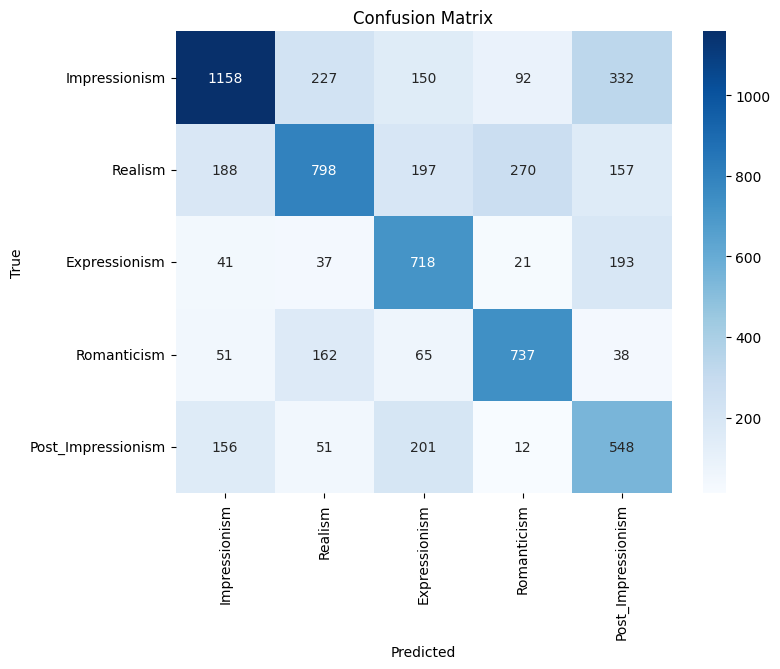

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=selected_classes,
    yticklabels=selected_classes
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

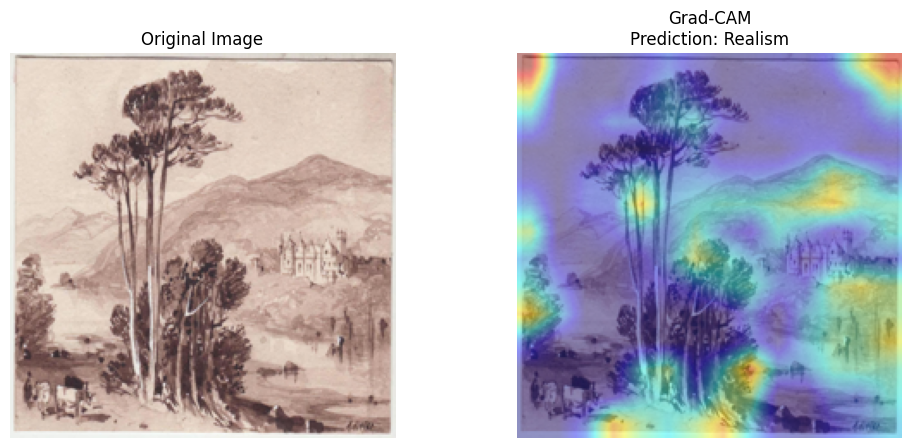

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch


gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

def forward_hook(module, input, output):
    global activations
    activations = output

def generate_gradcam(image_tensor, model):
    global gradients, activations
    
    
    target_layer = model.features[-2] 
    
  
    hook_handle_fwd = target_layer.register_forward_hook(forward_hook)
    hook_handle_bwd = target_layer.register_full_backward_hook(backward_hook)
    
   
    model.eval()
   
    model.zero_grad()
    
    output = model(image_tensor)
    predicted_class = output.argmax(dim=1).item()
    
  
    score = output[0, predicted_class]
    score.backward()
    
   
    hook_handle_fwd.remove()
    hook_handle_bwd.remove()
    
 
    grads = gradients.cpu().detach().numpy()[0]   
    fmap  = activations.cpu().detach().numpy()[0] 
    
   
    weights = np.mean(grads, axis=(1, 2))
    
    
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i]
        
  
    cam = np.maximum(cam, 0)
    
    
    cam = cv2.resize(cam, (224, 224))
    cam = cam - np.min(cam)
    cam = cam / (np.max(cam) + 1e-8) 
    
    return cam, predicted_class

def show_gradcam(image_path):
 
    for module in vgg16.modules():
        if isinstance(module, torch.nn.ReLU):
            module.inplace = False
            
   
    img = Image.open(image_path).convert('RGB')
    
   
    img_resized = img.resize((224, 224)) 
    
    
    input_tensor = val_test_transforms(img).unsqueeze(0).to(device)
    
  
    cam, pred_class_idx = generate_gradcam(input_tensor, vgg16)
    
    
    pred_class_name = selected_classes[pred_class_idx]
    
  
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) 
    
    img_np = np.array(img_resized)
    
    
    superimposed_img = heatmap * 0.4 + img_np * 0.6
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    
  
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_resized)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM\nPrediction: {pred_class_name}")
    plt.axis('off')
    
    plt.show()


vgg16 = vgg16.to(device)
vgg16.eval() 


show_gradcam(img_path)